# Contrôle d'un robot par commande vocale
Simon Gheeraert - Paul Jouhaud - Rémi Juge

## Simulation

In [88]:
import wave
import math
import time
import numpy as np
import itertools
import matplotlib.pyplot as plt
from scipy import signal, fftpack
from scipy.io.wavfile import read


%matplotlib inline

In [89]:
folder = "data/"

In [90]:
same_speaker_set = [ 
    {
        "filename": "enavant_1_paul.wav",
        "class": "en avant",
    }, {
        "filename": "adroite_1_paul.wav",
        "class": "à droite",
    }, {
        "filename": "agauche_1_paul.wav",
        "class": "à gauche",
    }, {
        "filename": "stop_1_paul.wav",
        "class": "stop",
    }
]
left_right_set = [
    {
        "filename": "adroite_1_paul.wav",
        "class": "à droite",
    }, {
        "filename": "adroite_1_remi.wav",
        "class": "à droite",
    }, {
        "filename": "agauche_1_paul.wav",
        "class": "à gauche",
    }, {
        "filename": "agauche_1_remi.wav",
        "class": "à gauche",
    }
]

### Filtre de préaccentuation
Dans la littérature concernant le traitement de la parole, on a pu régulièrement observer l'utilisation de filtres de préaccentuation. On a compris que c'était une vieille solution pour améliorer l'extraction de caractéristiques, qui n'était plus très utilisé actuellement.

Nous avons choisi de tester notre chaîne de classification, avec et sans ce filtre, et à chaque fois les résultats obtenus étaient légèrement meilleur lorsque nous utilisions ce filtre de préaccentuation. C'est donc logiquement que nous avons choisi de le garder dans notre pipeline.

Le filtre de préaccentuation va augmenter l'amplitude des bandes hautes-fréquences et diminuer celles des bandes basses-fréquences. Cette implémentation est basée sur l'idée que les hautes-fréquences permettent plus facilement de discriminer des signaux que les basses-fréquences. Généralement les hautes-fréquences ont des amplitudes plus faibles que les basses-fréquences, on rétablit ainsi un équilibre.

Ce filtre peut être implémenté avec l'équation suivante : $ y_t = x_t - \alpha x_{t-1}$. Les valeurs courantes pour $\alpha$ sont $\alpha = 0.95$ ou $\alpha = 0.97$, dans notre cas, nous utilisons $\alpha = 0.95$.

In [91]:
def apply_preemphasis_filter(data_signal):
    # Pre-Emphasis Filter
    pre_emphasis = 0.95
    emphasized_signal = np.append(data_signal[0], data_signal[1:] - pre_emphasis * data_signal[:-1])
    return emphasized_signal

In [92]:
def display_preemphasis_set(test_set, filename="test"):
    plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
    cols = 2
    rows = len(test_set)
    subplot_idx = 1
    for file in test_set:
        [fs, a] = read(folder + file.get('filename'))
        data_signal = np.array(a,dtype=float)
        plt.subplot(rows*100 + cols*10 + subplot_idx)
        plt.plot(data_signal)
        plt.title("Signal de classe " + file.get('class'))
        plt.ylabel('Amplitude')
        plt.xlabel('Échantillon')
        subplot_idx = subplot_idx + 1
        
        data_signal = apply_preemphasis_filter(data_signal)
        plt.title("Signal de classe " + file.get('class'))
        plt.ylabel('Amplitude')
        plt.xlabel('Échantillon')
        plt.subplot(rows*100 + cols*10 + subplot_idx)
        plt.plot(data_signal)
        plt.title("Signal de classe " + file.get('class') + " en sortie du filtre de préaccentuation")
        plt.ylabel('Amplitude')
        plt.xlabel('Échantillon')
        subplot_idx = subplot_idx + 1
        
    plt.tight_layout(pad=0.4, w_pad=2.5, h_pad=1.0)
    plt.savefig(filename + "_preemphasis.png")
    plt.show()
    

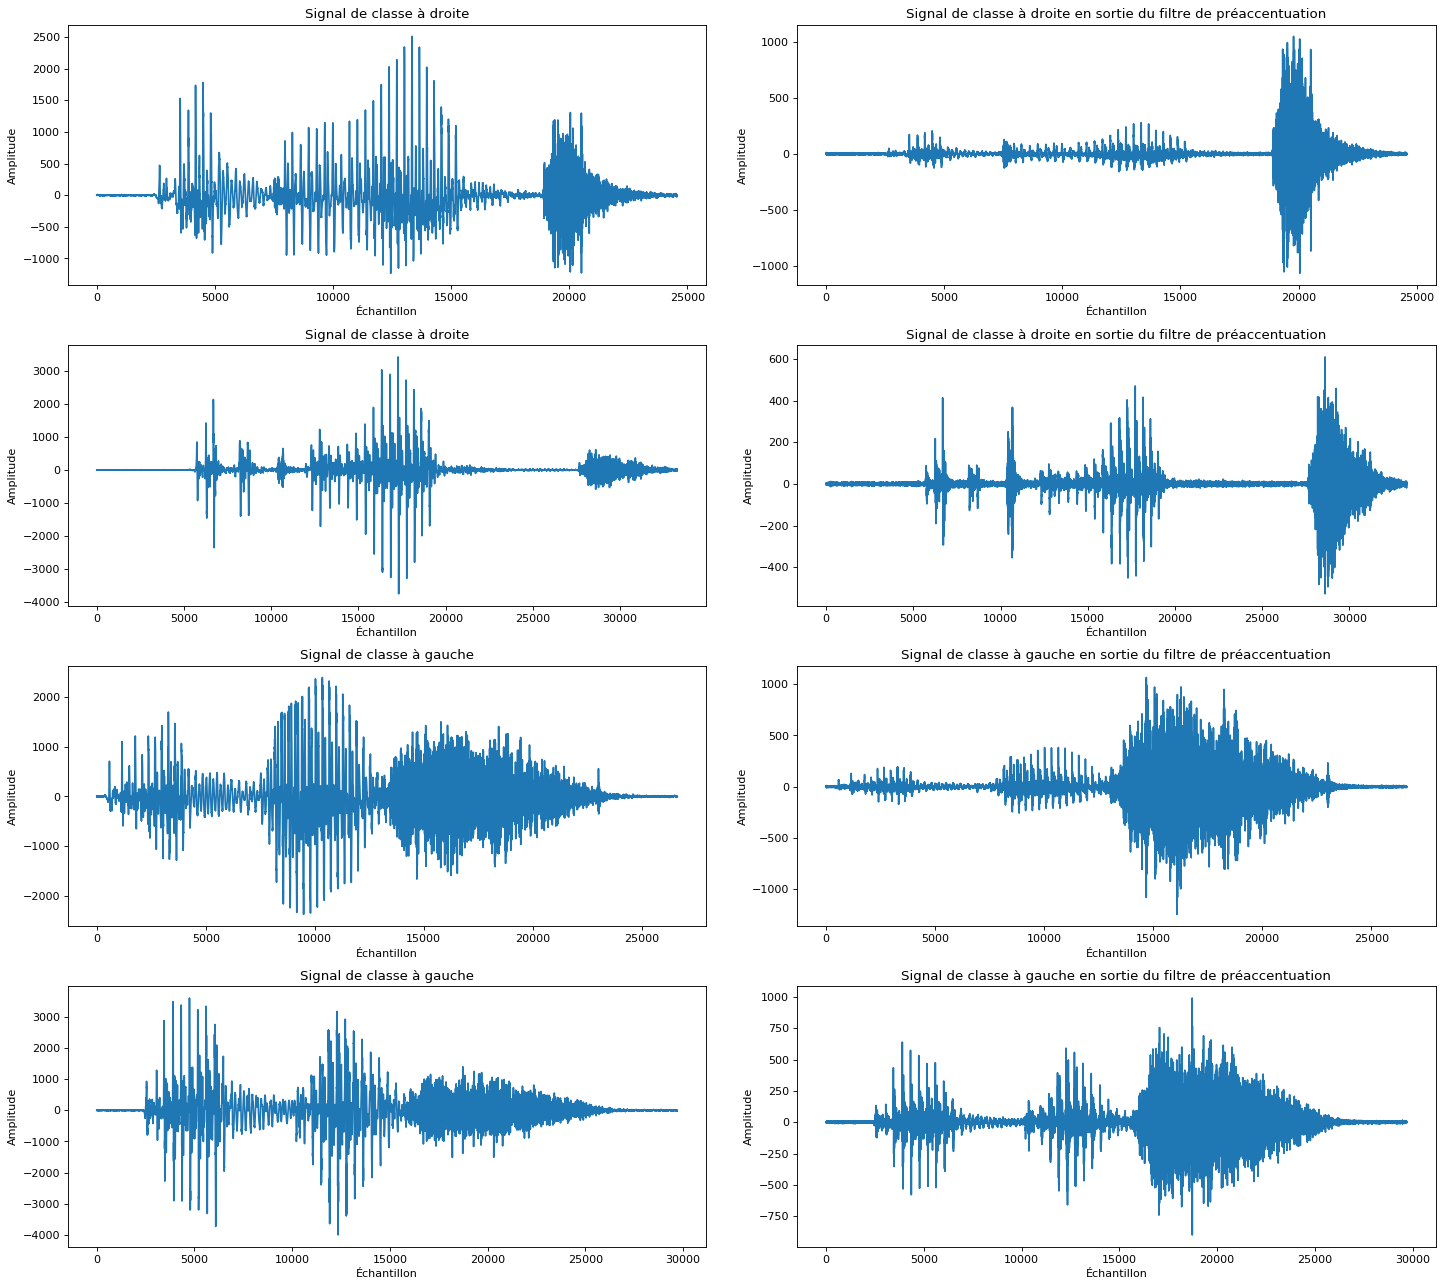

In [93]:
display_preemphasis_set(left_right_set, "left_right")

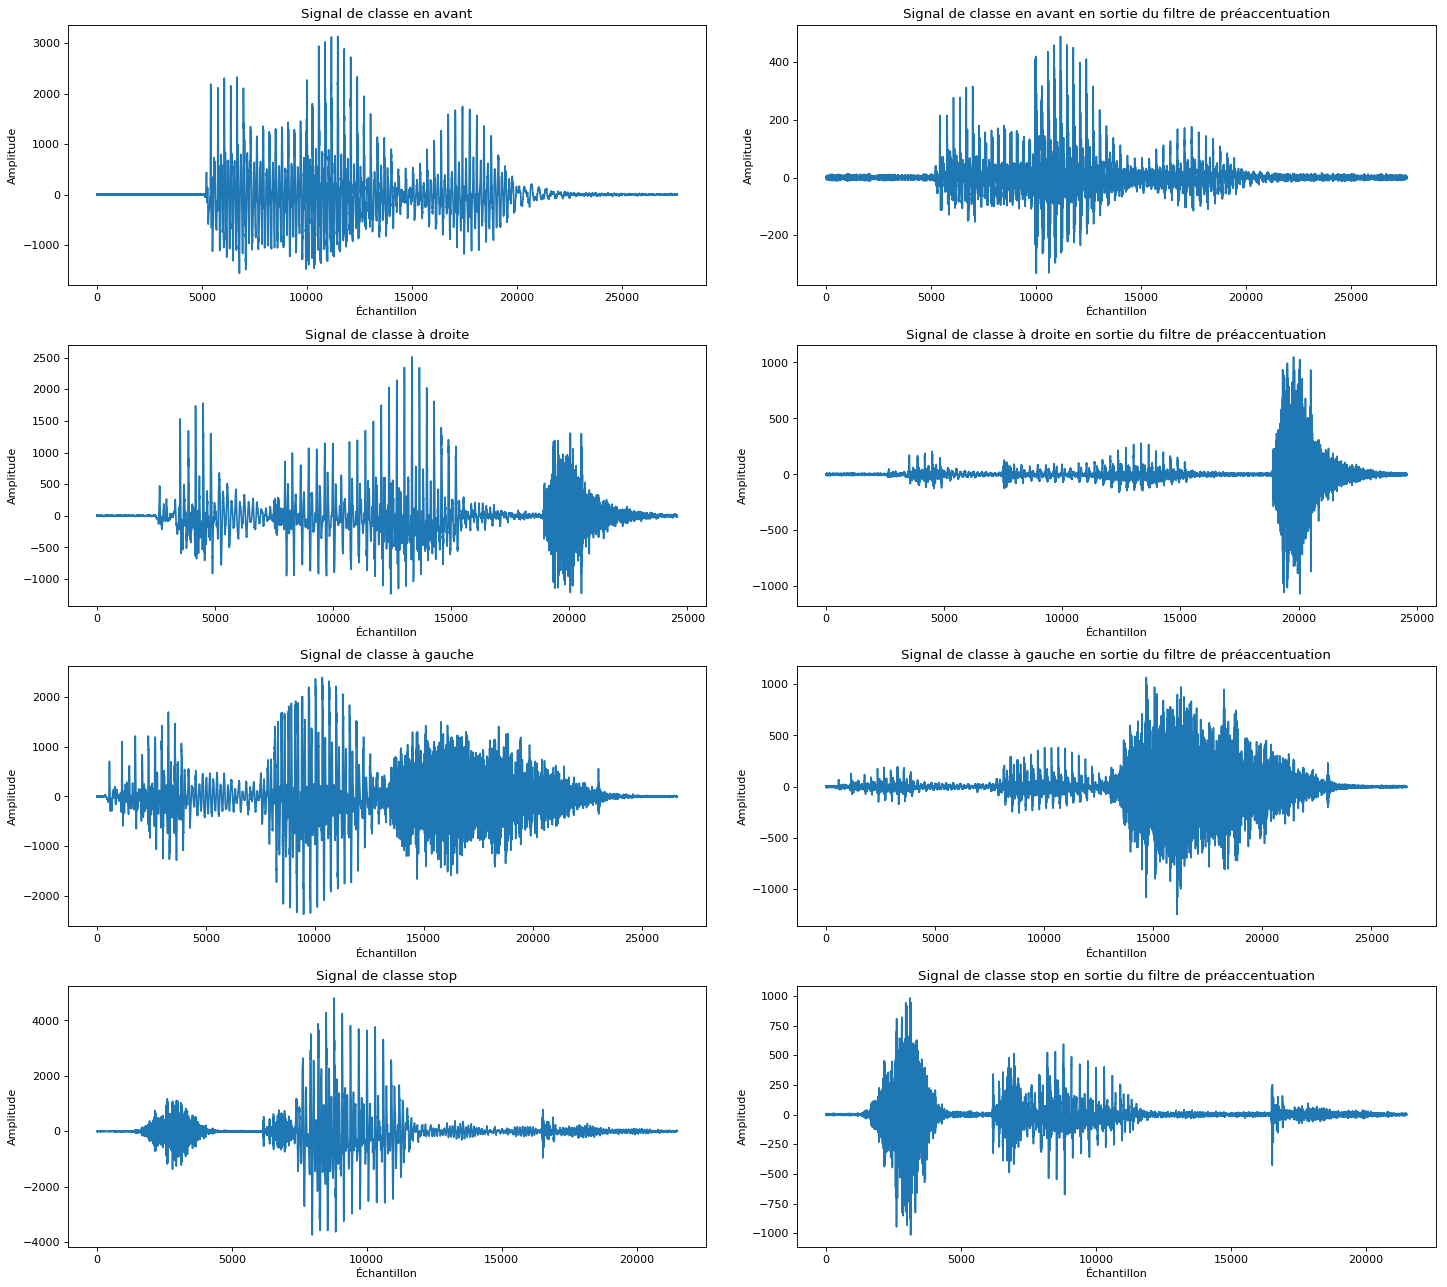

In [94]:
display_preemphasis_set(same_speaker_set, "same_speaker")

### Passage en fréquentiel
On doit diviser le signal en petites parties de quelques dizaines de millisecondes, typiquement entre 20 et 40ms. Afin d'avoir la meilleure représentation en fréquence du signal, il faut que celui-ci soit stable. Or on ne peut pas garantir cette stabilité sur de longues périodes temporelles, c'est pour ça que l'on va considérer des sous-parties beaucoup plus courtes, les frames.

Sur ces frames, on va appliquer une FFT pour passer d'une représentation temporelle à fréquentielle. En Python, le module Scipy possède une fonction Short-Time Fourier Transform, STFT. Cette fonction découpe notre signal en frame et applique directement la FFT à chacune des frames.

Nous avons choisi d'utiliser des frames de 20ms. La fenêtre que nous allons utiliser pour la FFT est celle de Hamming.

In [95]:
def apply_stft(data_signal, nperseg, overlap, fs, NFFT):
    # FFT
    window = 'hamming'
    f, t, Zxx = signal.stft(x = data_signal, fs=fs, nperseg=nperseg, noverlap=overlap, nfft=NFFT, window=window)
    return f, t, Zxx

In [96]:
def display_stft_set(test_set, filename="test"):
    plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
    cols = 2
    rows = len(test_set)
    subplot_idx = 1
    for file in test_set:
        [fs, a] = read(folder + file.get('filename'))
        data_signal = np.array(a,dtype=float)
        plt.subplot(rows*100 + cols*10 + subplot_idx)
        plt.plot(data_signal)
        plt.title("Signal de classe " + file.get('class'))
        plt.ylabel('Amplitude')
        plt.xlabel('Échantillon')
        subplot_idx = subplot_idx + 1
        data_signal = apply_preemphasis_filter(data_signal)
        nperseg = math.floor(fs*2/100)
        overlap = math.floor(nperseg/2)
        NFFT = 2*nperseg
        f, t, Zxx = apply_stft(data_signal, nperseg, overlap, fs, NFFT)
        plt.subplot(rows*100 + cols*10 + subplot_idx)
        plt.title("Signal de classe " + file.get('class'))
        plt.pcolormesh(np.abs(Zxx))
        subplot_idx = subplot_idx + 1
        
    plt.tight_layout(pad=0.4, w_pad=2.5, h_pad=1.0)
    plt.savefig(filename + "_stft.png")
    plt.show()

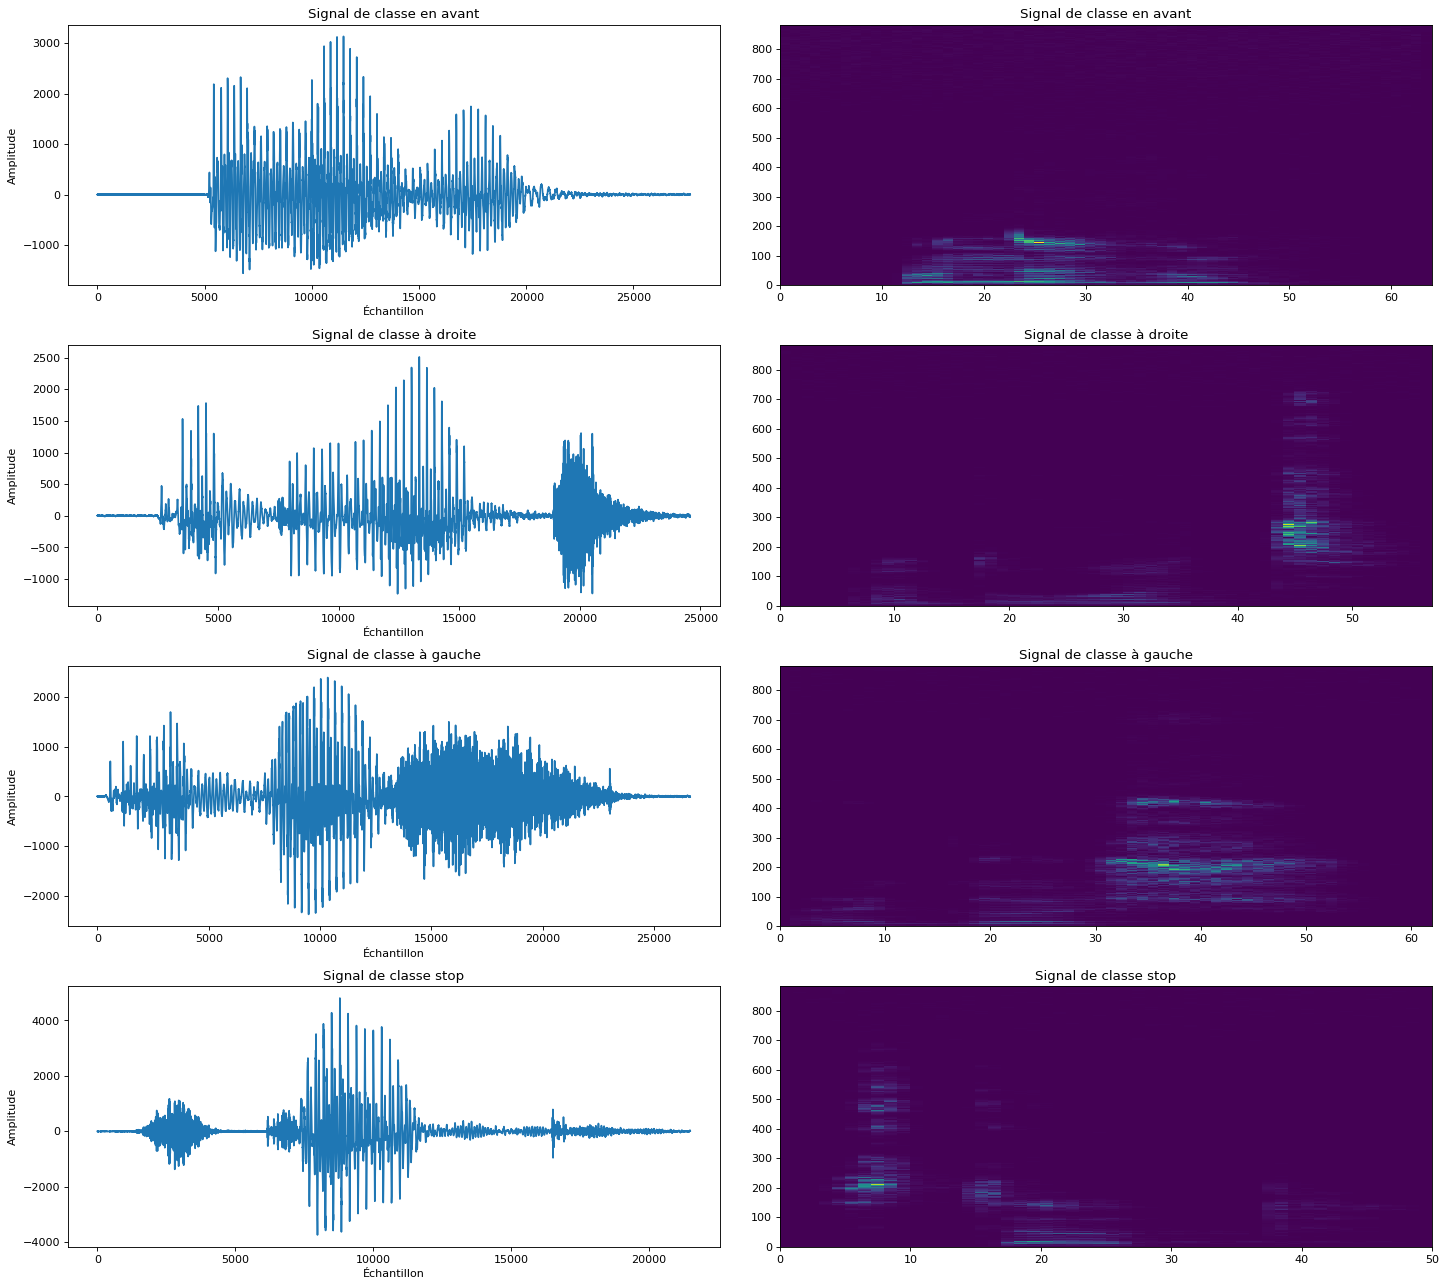

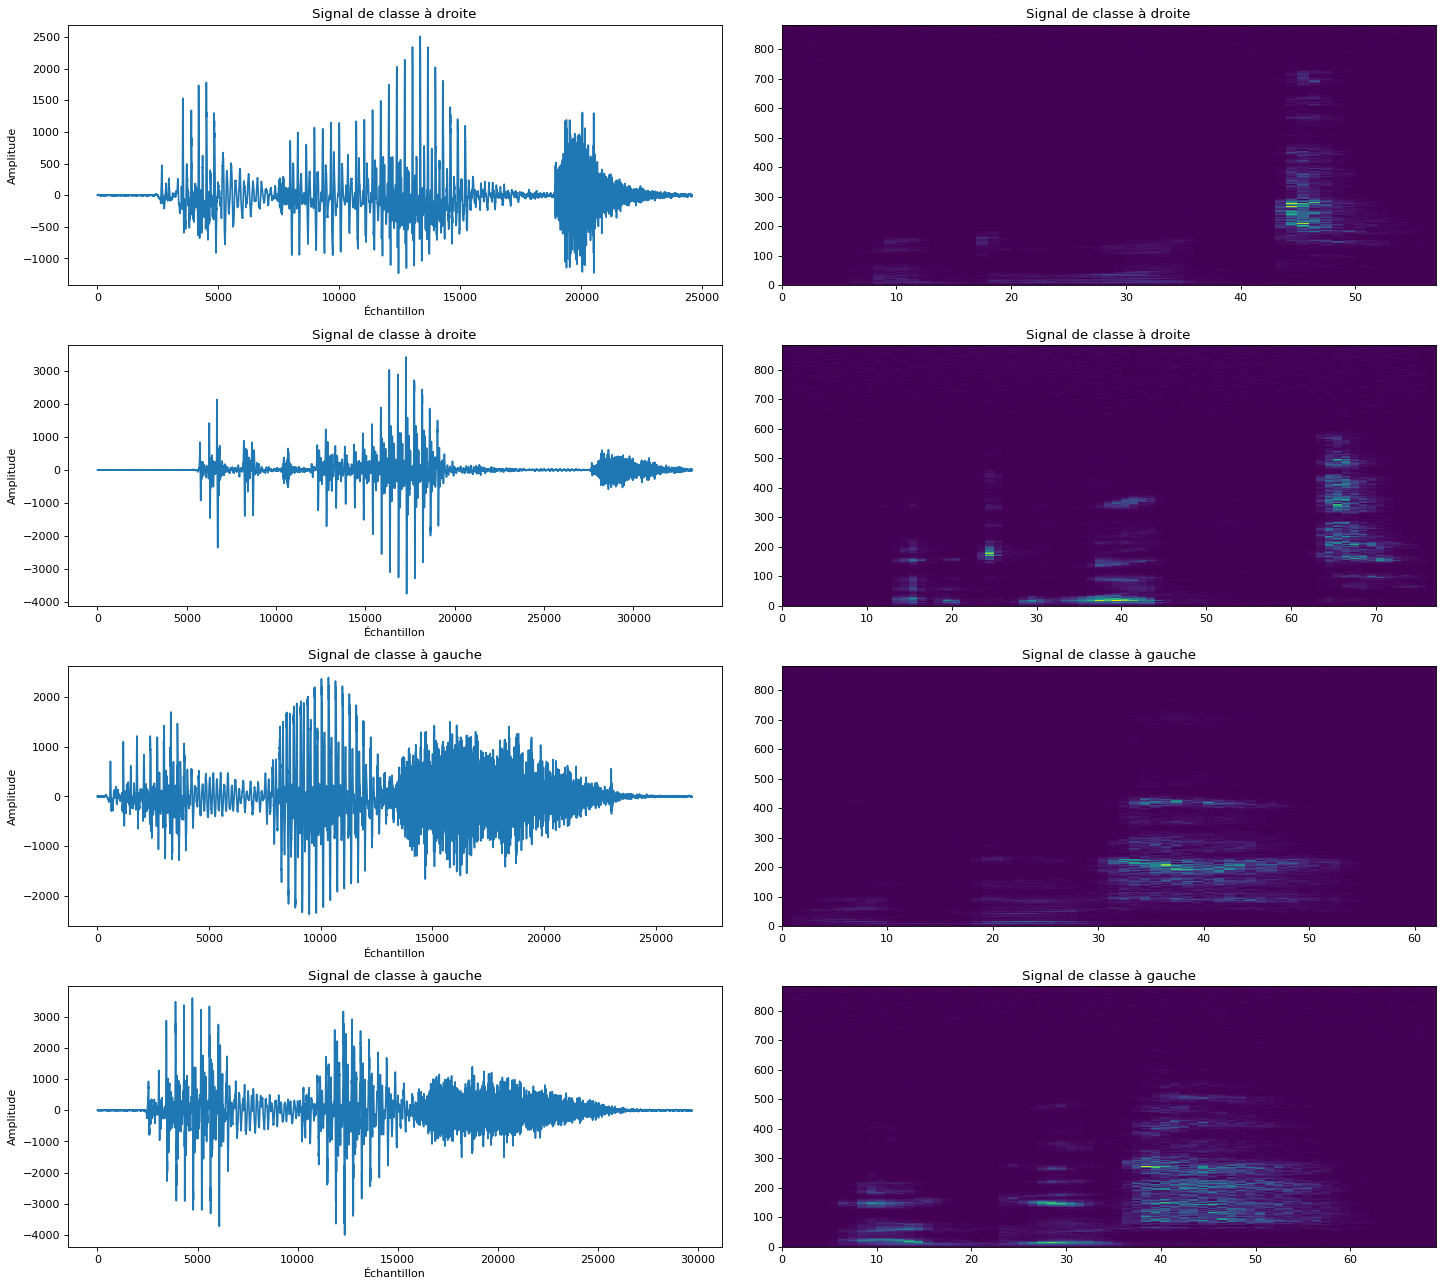

In [97]:
display_stft_set(same_speaker_set, "same_speaker")
display_stft_set(left_right_set, "left_right")

### Banque de filtres

In [98]:
def apply_filter_banks(Zxx, fs, NFFT):
    # Filter Banks
    nfilt = 40
    low_freq_mel = 0
    high_freq_mel = (2595 * np.log10(1 + (fs / 2) / 700))  # Convert Hz to Mel
    mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
    hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
    bin = np.floor((NFFT + 1) * hz_points / fs)

    fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
    for m in range(1, nfilt + 1):
        f_m_minus = int(bin[m - 1])   # left
        f_m = int(bin[m])             # center
        f_m_plus = int(bin[m + 1])    # right

        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
    filter_banks = np.dot(Zxx.T, fbank.T)
    filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Numerical Stability
    filter_banks = 20 * np.log10(filter_banks)  # dB
    return filter_banks

In [99]:
def display_filterbanks_set(test_set, filename="test"):
    plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
    cols = 2
    rows = len(test_set)
    subplot_idx = 1
    for file in test_set:
        [fs, a] = read(folder + file.get('filename'))
        data_signal = np.array(a,dtype=float)
        data_signal = apply_preemphasis_filter(data_signal)
        nperseg = math.floor(fs*2/100)
        overlap = math.floor(nperseg/2)
        NFFT = 2*nperseg
        f, t, Zxx = apply_stft(data_signal, nperseg, overlap, fs, NFFT)
        plt.subplot(rows*100 + cols*10 + subplot_idx)
        plt.title("Signal de classe " + file.get('class'))
        plt.pcolormesh(np.abs(Zxx))
        subplot_idx = subplot_idx + 1
       
        filter_banks = apply_filter_banks(Zxx, fs, NFFT)
        plt.subplot(rows*100 + cols*10 + subplot_idx)
        plt.title("Signal de classe " + file.get('class'))
        plt.pcolormesh(np.abs(filter_banks))
        subplot_idx = subplot_idx + 1
        
    plt.tight_layout(pad=0.4, w_pad=2.5, h_pad=1.0)
    plt.savefig(filename + "_filterbanks.png")
    plt.show()

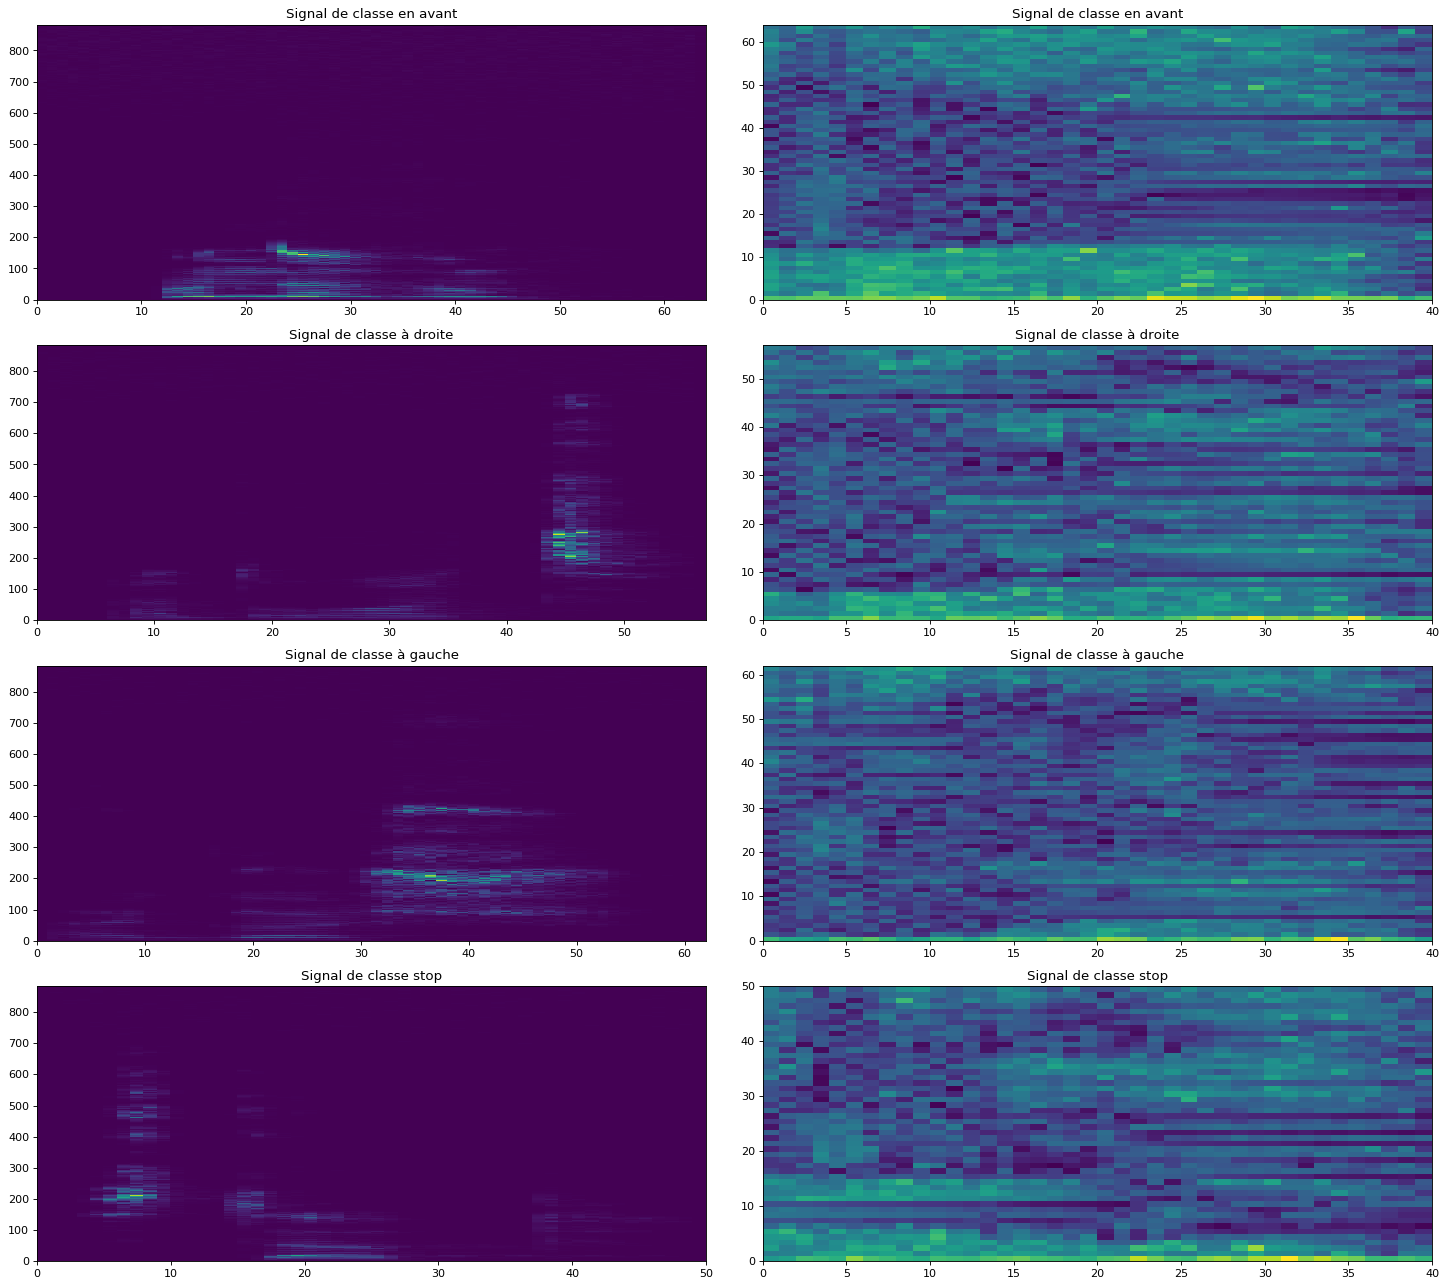

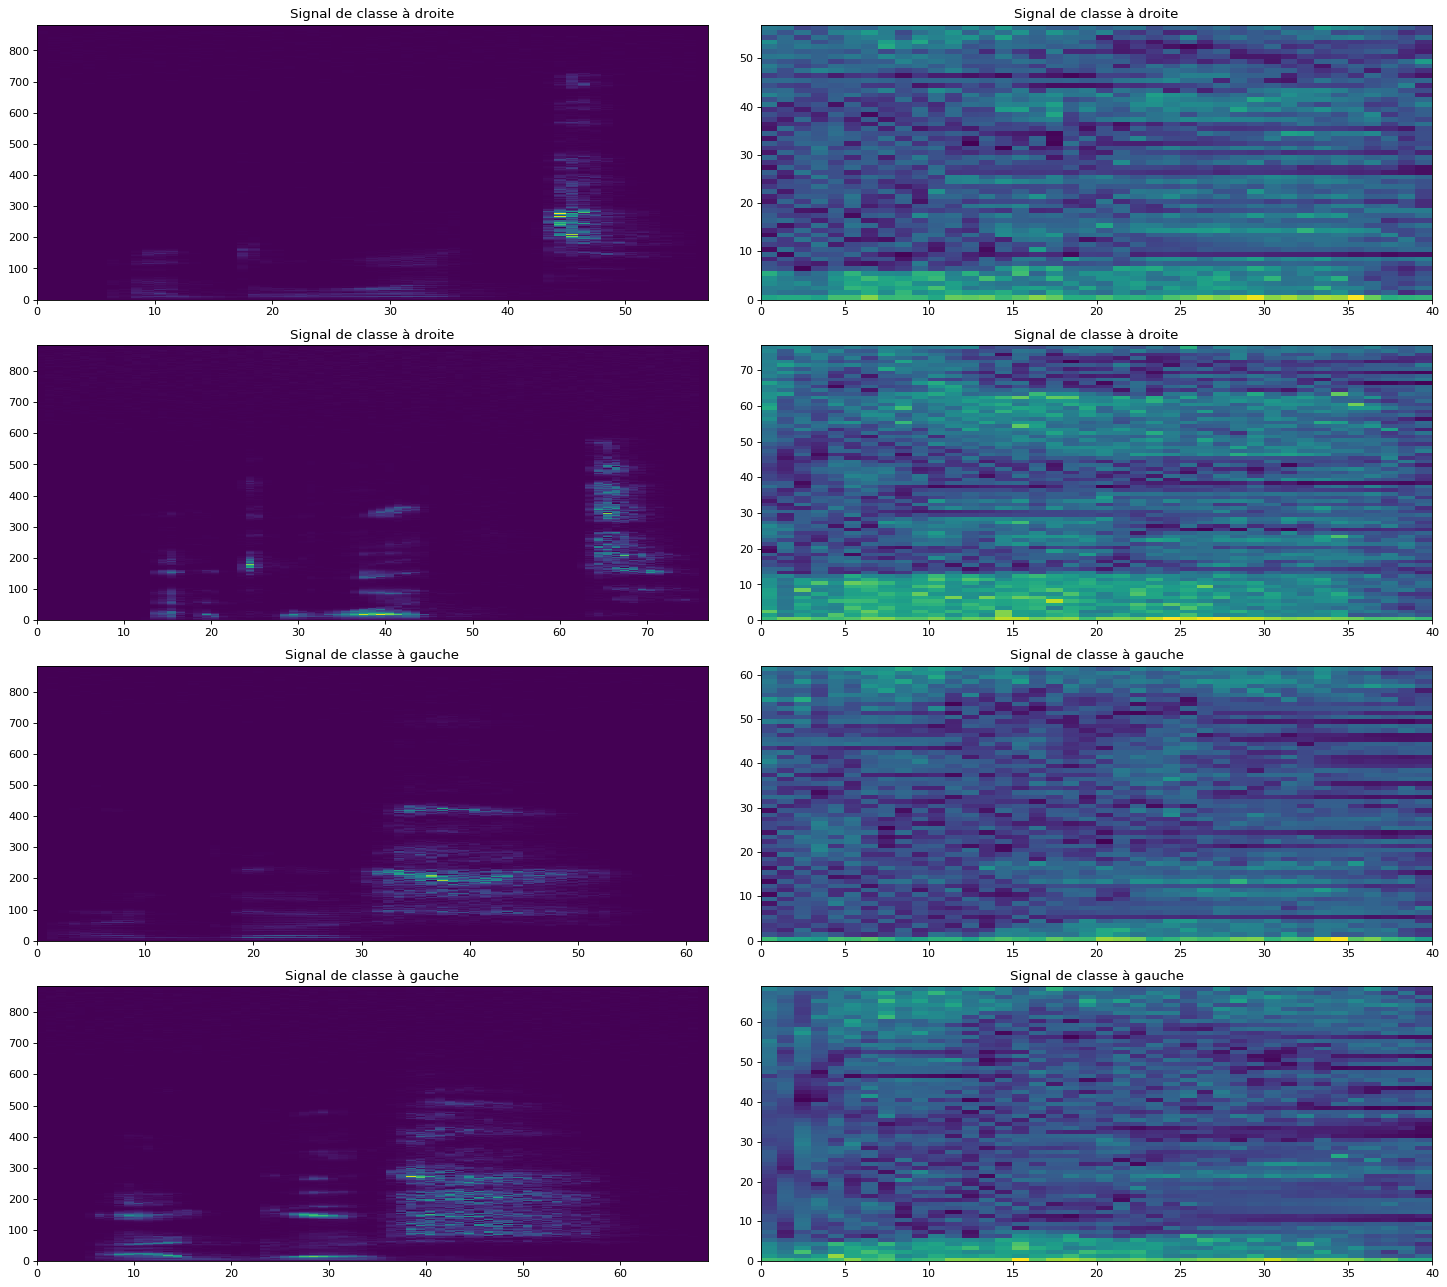

In [100]:
display_filterbanks_set(same_speaker_set, "same_speaker")
display_filterbanks_set(left_right_set, "left_right")

### MFCC

In [101]:
def apply_mfcc(filter_banks):
    # MFCC
    num_ceps = 12
    mfcc = fftpack.dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)]
    return mfcc

In [102]:
def display_mfcc_set(test_set, filename="test"):
    plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
    cols = 2
    rows = len(test_set)
    subplot_idx = 1
    for file in test_set:
        [fs, a] = read(folder + file.get('filename'))
        data_signal = np.array(a,dtype=float)
        data_signal = apply_preemphasis_filter(data_signal)
        nperseg = math.floor(fs*2/100)
        overlap = math.floor(nperseg/2)
        NFFT = 2*nperseg
        f, t, Zxx = apply_stft(data_signal, nperseg, overlap, fs, NFFT)       
        filter_banks = apply_filter_banks(Zxx, fs, NFFT)
        plt.subplot(rows*100 + cols*10 + subplot_idx)
        plt.title("Signal de classe " + file.get('class'))
        plt.pcolormesh(np.abs(filter_banks))
        subplot_idx = subplot_idx + 1
        
        mfcc = apply_mfcc(filter_banks)
        plt.subplot(rows*100 + cols*10 + subplot_idx)
        plt.title("Signal de classe " + file.get('class'))
        plt.pcolormesh(np.abs(mfcc))
        subplot_idx = subplot_idx + 1
        
    plt.tight_layout(pad=0.4, w_pad=2.5, h_pad=1.0)
    plt.savefig(filename + "_mfcc.png")
    
    plt.show()

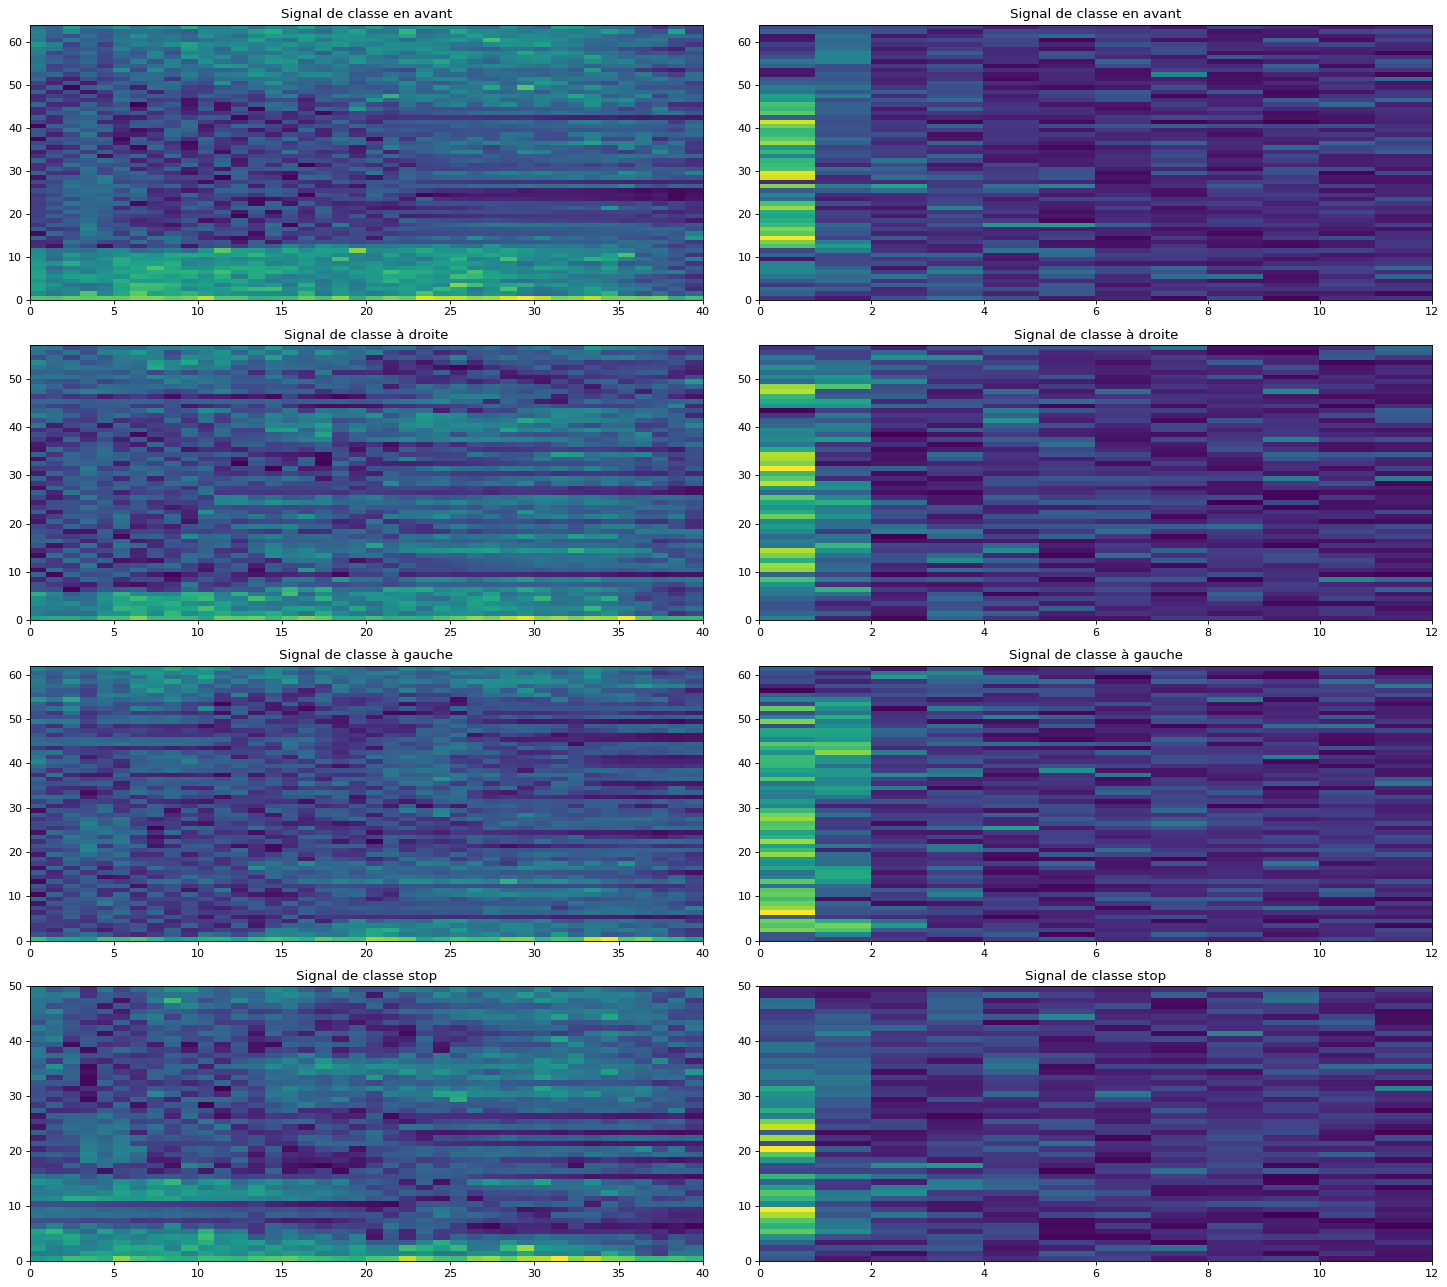

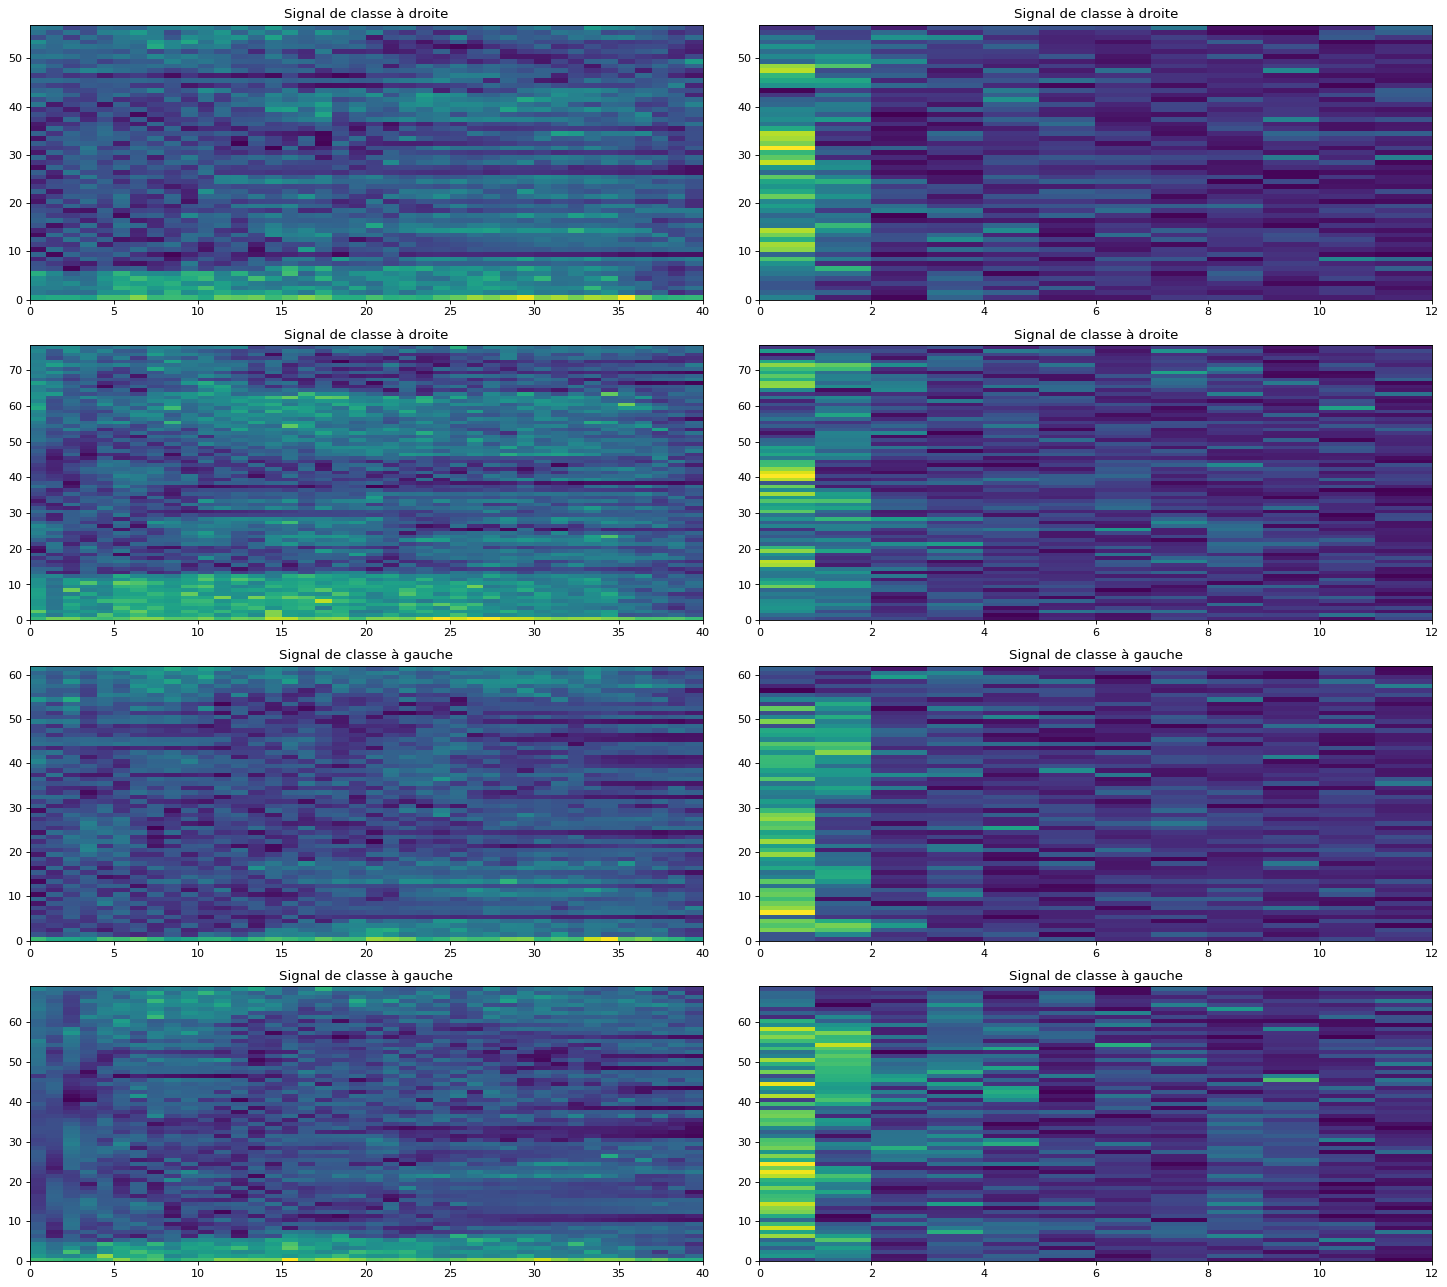

In [103]:
display_mfcc_set(same_speaker_set, "same_speaker")
display_mfcc_set(left_right_set, "left_right")

### Tout le pipeline

In [106]:
def display_set(test_set, filename="test"):
    plt.figure(figsize=(42, 16), dpi= 80, facecolor='w', edgecolor='k')
    cols = 5
    rows = len(test_set)
    subplot_idx = 1
    for file in test_set:
        [fs, a] = read(folder + file.get('filename'))
        plt.subplot(rows*100 + cols*10 + subplot_idx)
        plt.plot(a)
        plt.title("Signal de classe " + file.get('class'))
        plt.ylabel('Amplitude')
        plt.xlabel('Échantillon')
        subplot_idx = subplot_idx + 1
       
        data_signal = np.array(a,dtype=float)
        data_signal = apply_preemphasis_filter(data_signal)
        plt.subplot(rows*100 + cols*10 + subplot_idx)
        plt.plot(data_signal)
        plt.title("Signal de classe " + file.get('class'))
        plt.ylabel('Amplitude')
        plt.xlabel('Échantillon')
        subplot_idx = subplot_idx + 1
        
        nperseg = math.floor(fs*2/100)
        overlap = math.floor(nperseg/2)
        NFFT = 2*nperseg
        f, t, Zxx = apply_stft(data_signal, nperseg, overlap, fs, NFFT)
        plt.subplot(rows*100 + cols*10 + subplot_idx)
        plt.title("Signal de classe " + file.get('class'))
        plt.pcolormesh(np.abs(Zxx))
        subplot_idx = subplot_idx + 1
        
        filter_banks = apply_filter_banks(Zxx, fs, NFFT)
        plt.subplot(rows*100 + cols*10 + subplot_idx)
        plt.title("Signal de classe " + file.get('class'))
        plt.pcolormesh(np.abs(filter_banks))
        subplot_idx = subplot_idx + 1
        
        mfcc = apply_mfcc(filter_banks)
        plt.subplot(rows*100 + cols*10 + subplot_idx)
        plt.title("Signal de classe " + file.get('class'))
        plt.pcolormesh(np.abs(mfcc))
        subplot_idx = subplot_idx + 1
        
    plt.tight_layout(pad=0.4, w_pad=2.5, h_pad=1.0)
    plt.savefig(filename + ".png")
    
    plt.show()

ValueError: num must be 1 <= num <= 24, not 0

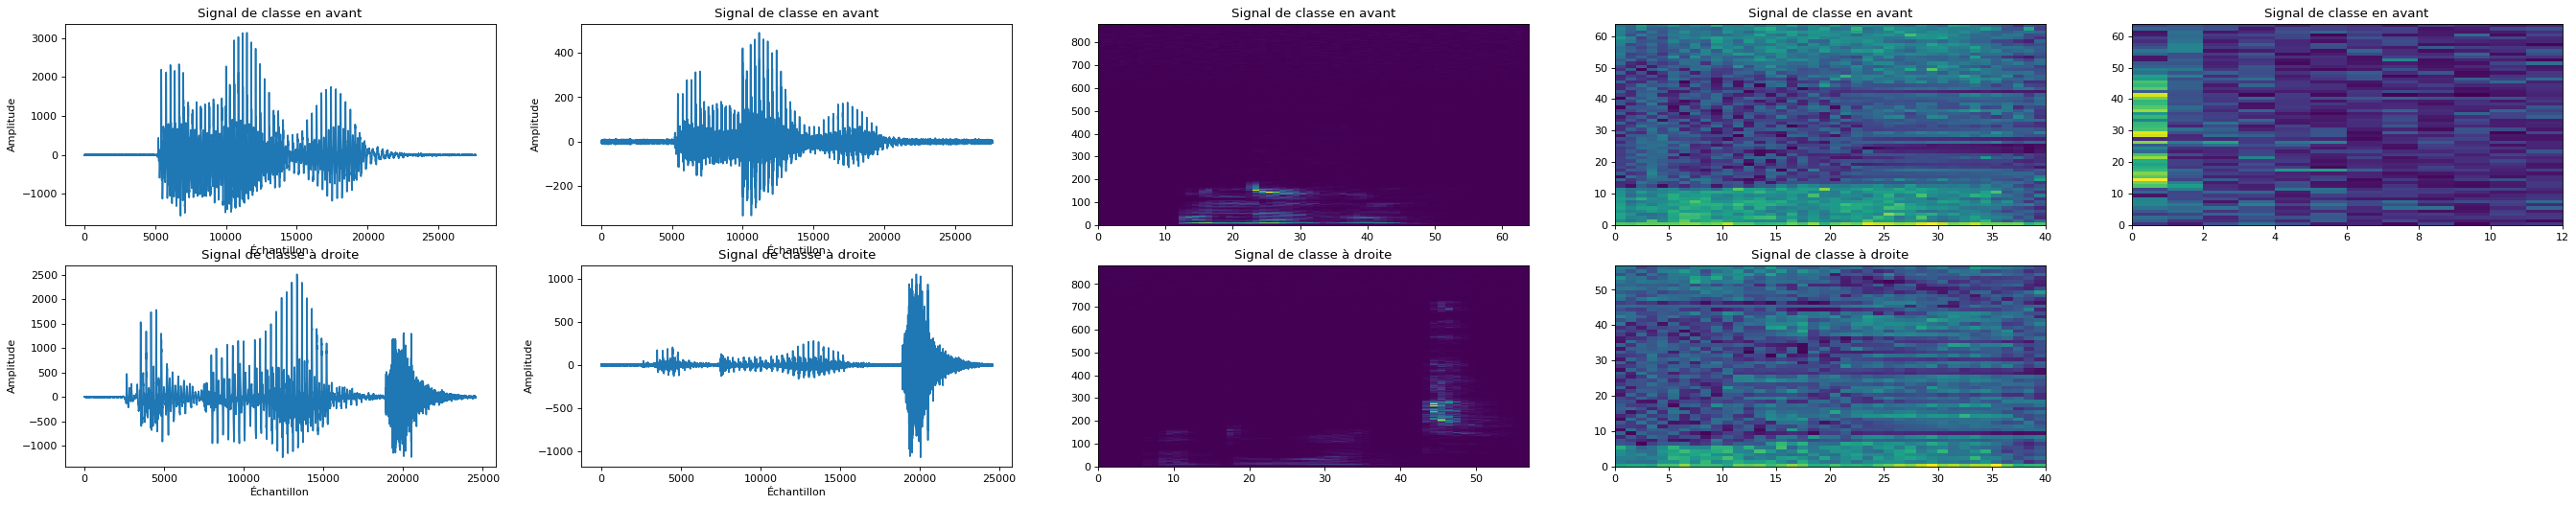

In [107]:
display_set(same_speaker_set, "same_speaker")
display_set(left_right_set, "left_right")